In [117]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
from datetime import datetime


start_date = '1985-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

actual_gdp = pdr.DataReader('GDPC1', 'fred', start_date, end_date)      
potential_gdp = pdr.DataReader('GDPPOT', 'fred', start_date, end_date)  

df = pd.concat([actual_gdp, potential_gdp], axis=1)
df.columns = ['Actual_GDP', 'Potential_GDP']

df['Output_Gap'] = 100 * (df['Actual_GDP'] - df['Potential_GDP']) / df['Potential_GDP']
df_monthly = df.resample('M').ffill()
df_monthly = df_monthly.loc['1985-01-01':]

In [118]:
# 从 FRED 获取“初次申请失业救济人数”数据（Fetch Initial Jobless Claims data from FRED）
# FRED 中该指标的代码是 ICSA（ICSA = Initial Claims, Seasonally Adjusted）
claims = pdr.DataReader('ICSA', 'fred', start_date, end_date)

# 计算4周移动平均（Calculate 4-week moving average）
claims['4W_MA'] = claims['ICSA'].rolling(window=4).mean()

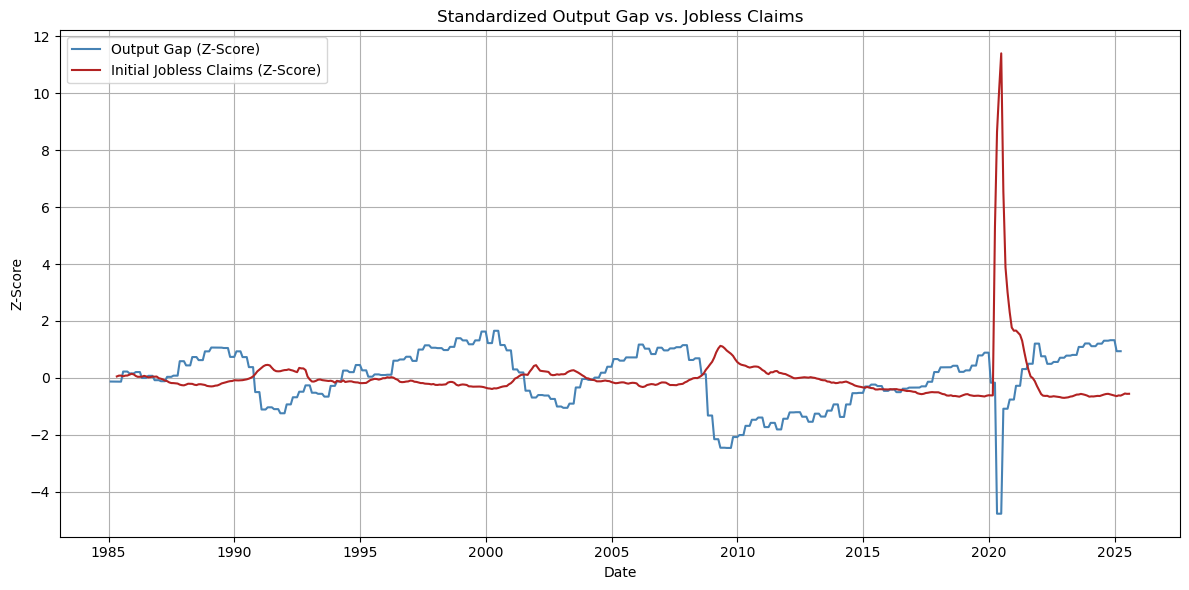

In [119]:
# 重采样 Jobless Claims 到月度，并计算 4W 均值
claims_monthly = claims.resample('M').ffill()
claims_monthly['4W_MA'] = claims_monthly['ICSA'].rolling(window=4).mean()
claims_monthly = claims_monthly.loc['1985-01-01':]

# 合并 Output Gap 和 Jobless Claims
df_combined = df_monthly.join(claims_monthly[['4W_MA']], how='inner')

# 标准化（Z-score normalization for trend comparison）
df_combined['Output_Gap_Z'] = (df_combined['Output_Gap'] - df_combined['Output_Gap'].mean()) / df_combined['Output_Gap'].std()
df_combined['Claims_Z'] = (df_combined['4W_MA'] - df_combined['4W_MA'].mean()) / df_combined['4W_MA'].std()

# 创建图表（Create plot）
plt.figure(figsize=(12, 6))

# 画 Output Gap（标准化）
plt.plot(df_combined.index, df_combined['Output_Gap_Z'], label='Output Gap (Z-Score)', color='steelblue')

# 画 Jobless Claims（标准化）
plt.plot(df_combined.index, df_combined['Claims_Z'], label='Initial Jobless Claims (Z-Score)', color='firebrick')

# 添加标签（Add title and labels）
plt.title('Standardized Output Gap vs. Jobless Claims')
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/z5/p623_8n54rg7n5k8q4brrmqw0000gn/T/ipykernel_5288/2559916644.py:10: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/envs/gdp_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


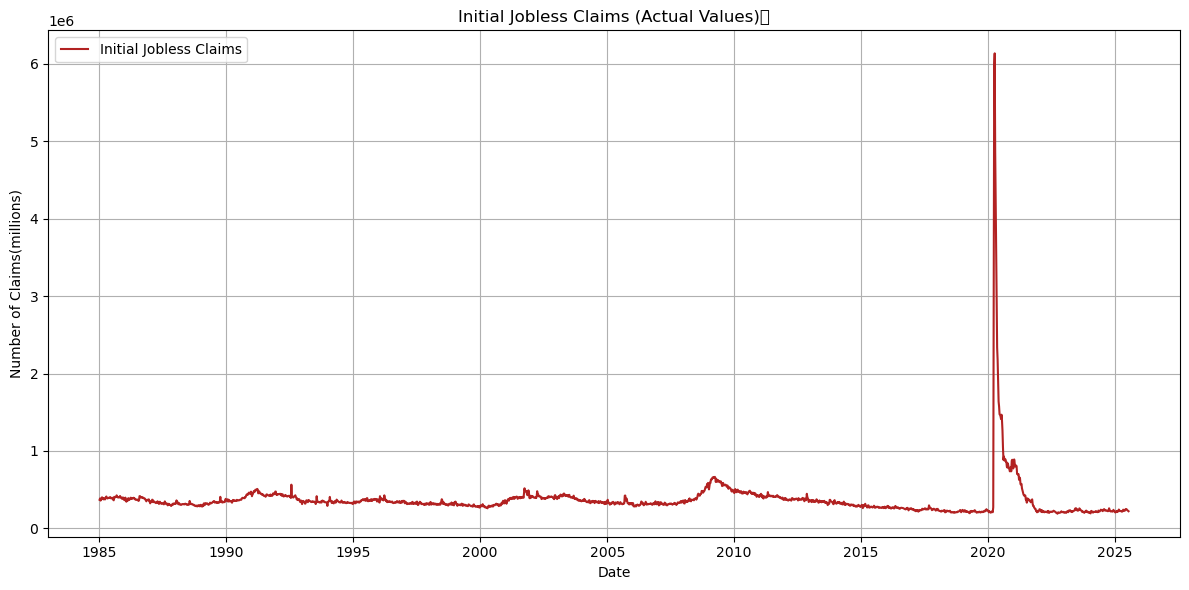

In [120]:
plt.figure(figsize=(12, 6))
plt.plot(claims.index, claims['ICSA'], label='Initial Jobless Claims', color='firebrick')

# === Step 4: 添加标题与标签（Add titles and labels）===
plt.title('Initial Jobless Claims (Actual Values)）')
plt.xlabel('Date')
plt.ylabel('Number of Claims(millions)')
plt.grid(True)
plt.legend()
plt.tight_layout()

# === Step 5: 显示图表（Show the plot）===
plt.show()

In [121]:
print(claims)

              ICSA     4W_MA
DATE                        
1985-01-05  369000       NaN
1985-01-12  387000       NaN
1985-01-19  359000       NaN
1985-01-26  368000  370750.0
1985-02-02  386000  375000.0
...            ...       ...
2025-06-14  246000  245750.0
2025-06-21  237000  245250.0
2025-06-28  232000  241250.0
2025-07-05  228000  235750.0
2025-07-12  221000  229500.0

[2115 rows x 2 columns]


In [122]:
import numpy as np
import statsmodels.api as sm

# dropna 后回归
# 只保留 Output_Gap 和 4W_MA 都非空的记录
df_model = df_combined[['Output_Gap_Z', 'Claims_Z']].copy()
df_model['Claims_Z_lag1'] = df_model['Claims_Z'].shift(1)
# dropna 后回归
df_model.replace([np.inf, -np.inf], np.nan, inplace=True)
df_model.dropna(inplace=True)  # 删除 NaN

# 准备回归
X = sm.add_constant(df_model['Claims_Z_lag1'])  # 添加常数项
y = df_model['Output_Gap_Z']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Output_Gap_Z   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     162.9
Date:                Mon, 21 Jul 2025   Prob (F-statistic):           2.65e-32
Time:                        14:05:13   Log-Likelihood:                -610.76
No. Observations:                 479   AIC:                             1226.
Df Residuals:                     477   BIC:                             1234.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0041      0.040      0.104

In [123]:
print(df_combined)

            Actual_GDP  Potential_GDP  Output_Gap     4W_MA  Output_Gap_Z  \
DATE                                                                        
1985-01-31    8400.820    8465.293021   -0.761616       NaN     -0.128380   
1985-02-28    8400.820    8465.293021   -0.761616       NaN     -0.128380   
1985-03-31    8400.820    8465.293021   -0.761616       NaN     -0.128380   
1985-04-30    8474.787    8540.419380   -0.768491  382500.0     -0.132195   
1985-05-31    8474.787    8540.419380   -0.768491  389500.0     -0.132195   
...                ...            ...         ...       ...           ...   
2025-03-31   23512.717   23243.220000    1.159465  220250.0      0.937631   
2025-04-30         NaN   23376.070000         NaN  228250.0           NaN   
2025-05-31         NaN   23376.070000         NaN  237750.0           NaN   
2025-06-30         NaN   23376.070000         NaN  235000.0           NaN   
2025-07-31         NaN   23510.180000         NaN  235500.0           NaN   

<Axes: xlabel='DATE'>

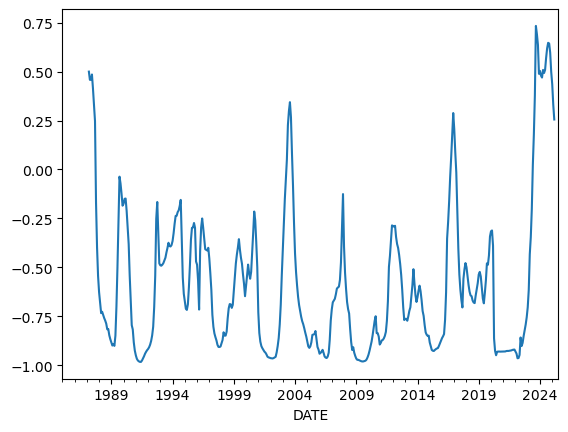

In [124]:
rolling_corr = df_combined['Output_Gap_Z'].rolling(24).corr(df_combined['Claims_Z'])
rolling_corr.plot()

In [125]:
# Step 1: 计算 rolling correlation（24个月）
df_combined['rolling_corr'] = df_combined['Output_Gap_Z'].rolling(24).corr(df_combined['Claims_Z'])

# Step 2: 构造 Regime 过滤器（相关性 <-0.5 为显著负相关）
df_combined['Regime'] = (df_combined['rolling_corr'] < -0.7).astype(int)

# Step 3: 提取 Regime == 1 时期的观测点（回归用）
df_regime = df_combined[df_combined['Regime'] == 1].copy()

# Step 4: 清洗数据
df_regime = df_regime[['Output_Gap_Z', 'Claims_Z']].replace([np.inf, -np.inf], np.nan).dropna()

# Step 5: 回归
X = sm.add_constant(df_regime['Claims_Z'])
y = df_regime['Output_Gap_Z']
model = sm.OLS(y, X).fit()

# Step 6: 输出结果
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Output_Gap_Z   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     124.2
Date:                Mon, 21 Jul 2025   Prob (F-statistic):           4.42e-23
Time:                        14:05:13   Log-Likelihood:                -290.34
No. Observations:                 218   AIC:                             584.7
Df Residuals:                     216   BIC:                             591.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1548      0.063     -2.442      0.0

/var/folders/z5/p623_8n54rg7n5k8q4brrmqw0000gn/T/ipykernel_5288/3793613398.py:18: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/envs/gdp_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


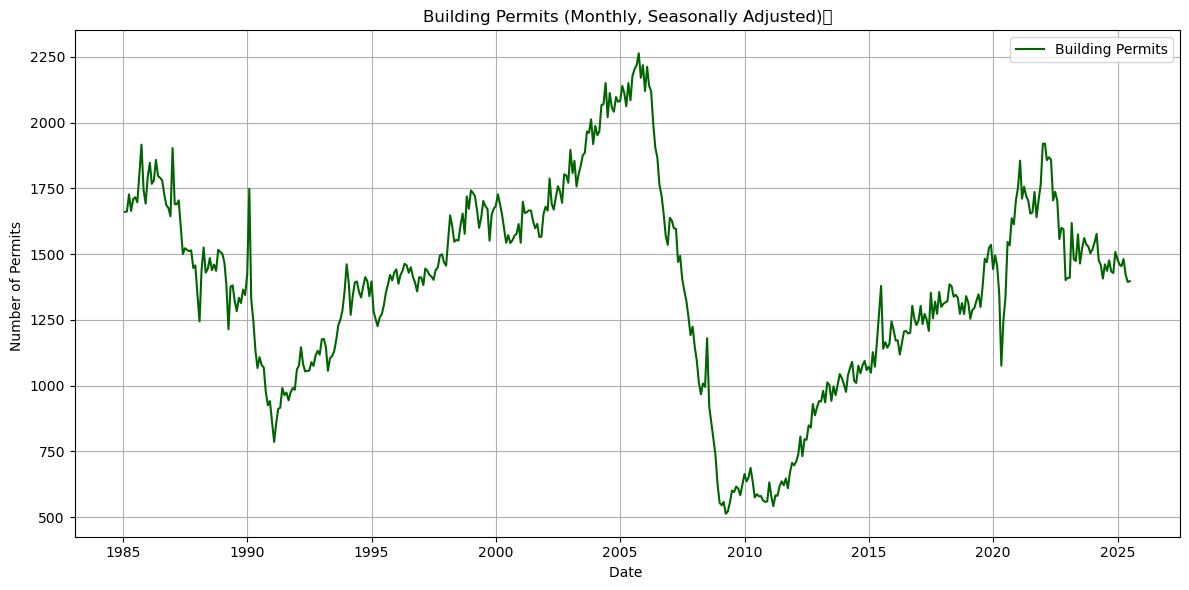

In [126]:
# === Step 2: 从FRED获取Building Permits数据（Fetch Building Permits data from FRED）===
# FRED代码为：PERMIT（新住宅单位许可数，季调后，月频）
permits = pdr.DataReader('PERMIT', 'fred', start_date, end_date)

# === Step 3: 重采样为月频并填补缺失值（Resample to monthly frequency）===
permits_monthly = permits.resample('M').ffill()

# === Step 4: 绘图（Plot actual values of Building Permits）===
plt.figure(figsize=(12, 6))
plt.plot(permits_monthly.index, permits_monthly['PERMIT'], color='darkgreen', label='Building Permits')

plt.title('Building Permits (Monthly, Seasonally Adjusted)）')
plt.xlabel('Date ')
plt.ylabel('Number of Permits ')
plt.ticklabel_format(style='plain', axis='y')  # 设置Y轴为普通数字
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [127]:
# FRED代码为：PERMIT（新住宅单位许可数，季调后，月频）
permits = pdr.DataReader('PERMIT', 'fred', start_date, end_date)

# === Step 3: 重采样为月频并填补缺失值（Resample to monthly frequency）===
permits_monthly = permits.resample('M').ffill()

permits_monthly_combined = permits_monthly.join(df_combined['Output_Gap_Z'], how='inner')


In [128]:
print(permits_monthly_combined)


            PERMIT  Output_Gap_Z
DATE                            
1985-01-31    1660     -0.128380
1985-02-28    1662     -0.128380
1985-03-31    1727     -0.128380
1985-04-30    1664     -0.132195
1985-05-31    1709     -0.132195
...            ...           ...
2025-02-28    1454      0.937631
2025-03-31    1481      0.937631
2025-04-30    1422           NaN
2025-05-31    1394           NaN
2025-06-30    1397           NaN

[486 rows x 2 columns]


In [129]:
permits_monthly_combined['permit_z'] = (permits_monthly_combined['PERMIT'] - permits_monthly_combined['PERMIT'].mean()) / permits_monthly_combined['PERMIT'].std()
print(permits_monthly_combined)

            PERMIT  Output_Gap_Z  permit_z
DATE                                      
1985-01-31    1660     -0.128380  0.727409
1985-02-28    1662     -0.128380  0.732636
1985-03-31    1727     -0.128380  0.902508
1985-04-30    1664     -0.132195  0.737863
1985-05-31    1709     -0.132195  0.855466
...            ...           ...       ...
2025-02-28    1454      0.937631  0.189047
2025-03-31    1481      0.937631  0.259609
2025-04-30    1422           NaN  0.105418
2025-05-31    1394           NaN  0.032243
2025-06-30    1397           NaN  0.040083

[486 rows x 3 columns]


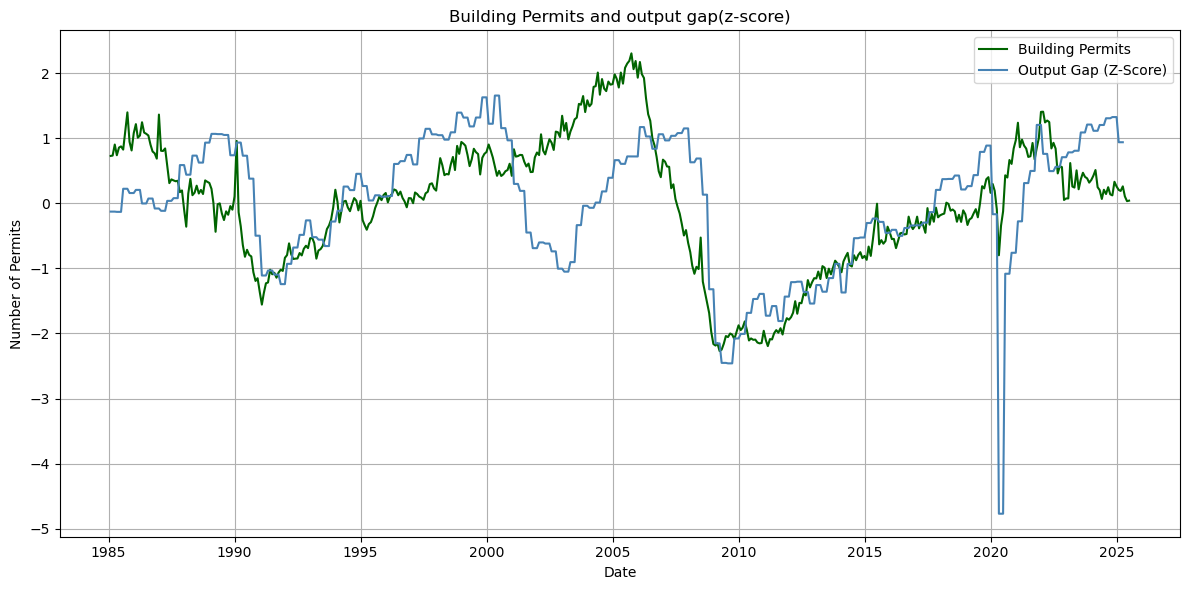

In [130]:
# === Step 4: 绘图（Plot actual values of Building Permits）===
plt.figure(figsize=(12, 6))
plt.plot(permits_monthly_combined.index, permits_monthly_combined['permit_z'], color='darkgreen', label='Building Permits')
plt.plot(df_combined.index, df_combined['Output_Gap_Z'], label='Output Gap (Z-Score)', color='steelblue')
plt.title('Building Permits and output gap(z-score)')
plt.xlabel('Date')
plt.ylabel('Number of Permits')
plt.ticklabel_format(style='plain', axis='y')  # 设置Y轴为普通数字
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [131]:
# dropna 后回归
# 只保留 Output_Gap 和 4W_MA 都非空的记录
df_model2 = permits_monthly_combined[['permit_z','Output_Gap_Z']].copy()
# dropna 后回归
df_model2.replace([np.inf, -np.inf], np.nan, inplace=True)
df_model2.dropna(inplace=True)  # 删除 NaN

# 准备回归
X = sm.add_constant(df_model2['permit_z'])  # 添加常数项
y = df_model2['Output_Gap_Z']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Output_Gap_Z   R-squared:                       0.351
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     259.9
Date:                Mon, 21 Jul 2025   Prob (F-statistic):           4.63e-47
Time:                        14:05:13   Log-Likelihood:                -580.52
No. Observations:                 483   AIC:                             1165.
Df Residuals:                     481   BIC:                             1173.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.037      0.006      0.9

In [132]:
dfx = pd.read_excel('2012-2018.xlsx', header=None)
dow1 = dfx.iloc[[8,21],]
print(dow1)

                    0         1      2         3         4         5   \
8                  NaN    Ticker  Field  Nov 2018  Oct 2018  Sep 2018   
21          New orders  NAPMNEWO  PR005      60.9      59.1      61.1   

          6         7         8         9   ...        73        74        75  \
8   Aug 2018  Jul 2018  Jun 2018  May 2018  ...  Jan 2013  Dec 2012  Nov 2012   
21      63.8      58.9      64.6      62.7  ...      54.9      48.3      47.9   

          76        77        78        79        80        81        82  
8   Oct 2012  Sep 2012  Aug 2012  Jul 2012  Jun 2012  May 2012  Apr 2012  
21      51.8      52.2      45.1      47.8      47.3      58.2      59.2  

[2 rows x 83 columns]


In [133]:
dow1

,0,1,2,3,4,5,6,7,8,9,...,73,74,75,76,77,78,79,80,81,82
8,NaN,Ticker,Field,Nov 2018,Oct 2018,Sep 2018,Aug 2018,Jul 2018,Jun 2018,May 2018,...,Jan 2013,Dec 2012,Nov 2012,Oct 2012,Sep 2012,Aug 2012,Jul 2012,Jun 2012,May 2012,Apr 2012
21,New orders,NAPMNEWO,PR005,60.9,59.1,61.1,63.8,58.9,64.6,62.7,...,54.9,48.3,47.9,51.8,52.2,45.1,47.8,47.3,58.2,59.2


In [134]:
dow1=dow1.drop(columns=[0,1,2])
print(dow1)

          3         4         5         6         7         8         9   \
8   Nov 2018  Oct 2018  Sep 2018  Aug 2018  Jul 2018  Jun 2018  May 2018   
21      60.9      59.1      61.1      63.8      58.9      64.6      62.7   

          10        11        12  ...        73        74        75        76  \
8   Apr 2018  Mar 2018  Feb 2018  ...  Jan 2013  Dec 2012  Nov 2012  Oct 2012   
21      62.7      61.6      64.9  ...      54.9      48.3      47.9      51.8   

          77        78        79        80        81        82  
8   Sep 2012  Aug 2012  Jul 2012  Jun 2012  May 2012  Apr 2012  
21      52.2      45.1      47.8      47.3      58.2      59.2  

[2 rows x 80 columns]


In [135]:
date_row=dow1.loc[8]
dates=pd.to_datetime(date_row.values,format='%b %Y')
no=dow1.loc[21].values
dow1=pd.DataFrame({
    'Date': dates,
    'ISM New Orders': no
})
print(dow1)

         Date ISM New Orders
0  2018-11-01           60.9
1  2018-10-01           59.1
2  2018-09-01           61.1
3  2018-08-01           63.8
4  2018-07-01           58.9
..        ...            ...
75 2012-08-01           45.1
76 2012-07-01           47.8
77 2012-06-01           47.3
78 2012-05-01           58.2
79 2012-04-01           59.2

[80 rows x 2 columns]


In [136]:
dfy = pd.read_excel('2018-2025.xlsx', header=None)
dow2 = dfy.iloc[[8,21],]
print(dow2)

                    0         1      2         3         4         5   \
8                  NaN    Ticker  Field  Jun 2025  May 2025  Apr 2025   
21          New orders  NAPMNEWO  PR005      46.4      47.6      47.2   

          6         7         8         9   ...        73        74        75  \
8   Mar 2025  Feb 2025  Jan 2025  Dec 2024  ...  Aug 2019  Jul 2019  Jun 2019   
21      45.2      48.6      55.1      52.1  ...      46.4      50.5      50.7   

          76        77        78        79        80        81        82  
8   May 2019  Apr 2019  Mar 2019  Feb 2019  Jan 2019  Dec 2018  Nov 2018  
21      52.5      53.5      56.6      55.9        57      52.5      60.9  

[2 rows x 83 columns]


In [137]:
dow2=dow2.drop(columns=[0,1,2])
print(dow2)

          3         4         5         6         7         8         9   \
8   Jun 2025  May 2025  Apr 2025  Mar 2025  Feb 2025  Jan 2025  Dec 2024   
21      46.4      47.6      47.2      45.2      48.6      55.1      52.1   

          10        11        12  ...        73        74        75        76  \
8   Nov 2024  Oct 2024  Sep 2024  ...  Aug 2019  Jul 2019  Jun 2019  May 2019   
21      50.3      47.9      46.7  ...      46.4      50.5      50.7      52.5   

          77        78        79        80        81        82  
8   Apr 2019  Mar 2019  Feb 2019  Jan 2019  Dec 2018  Nov 2018  
21      53.5      56.6      55.9        57      52.5      60.9  

[2 rows x 80 columns]


In [138]:
d_row=dow2.loc[8]
date=pd.to_datetime(d_row.values,format='%b %Y')

In [139]:
no2=dow2.loc[21].values
dow2=pd.DataFrame({
    'Date': date,
    'ISM New Orders': no2
})
print(dow2)

         Date ISM New Orders
0  2025-06-01           46.4
1  2025-05-01           47.6
2  2025-04-01           47.2
3  2025-03-01           45.2
4  2025-02-01           48.6
..        ...            ...
75 2019-03-01           56.6
76 2019-02-01           55.9
77 2019-01-01             57
78 2018-12-01           52.5
79 2018-11-01           60.9

[80 rows x 2 columns]


In [140]:
df_neworder = pd.concat([dow1, dow2], axis=0)

#drop duplicates
df_neworder = df_neworder.drop_duplicates(subset='Date')

#sort
df_neworder = df_neworder.sort_values(by='Date').reset_index(drop=True)

print(df_neworder)

          Date ISM New Orders
0   2012-04-01           59.2
1   2012-05-01           58.2
2   2012-06-01           47.3
3   2012-07-01           47.8
4   2012-08-01           45.1
..         ...            ...
154 2025-02-01           48.6
155 2025-03-01           45.2
156 2025-04-01           47.2
157 2025-05-01           47.6
158 2025-06-01           46.4

[159 rows x 2 columns]


In [141]:
df_neworder['Date'] = pd.to_datetime(df_neworder['Date'])

# 设置为索引
df_neworder.set_index('Date', inplace=True)

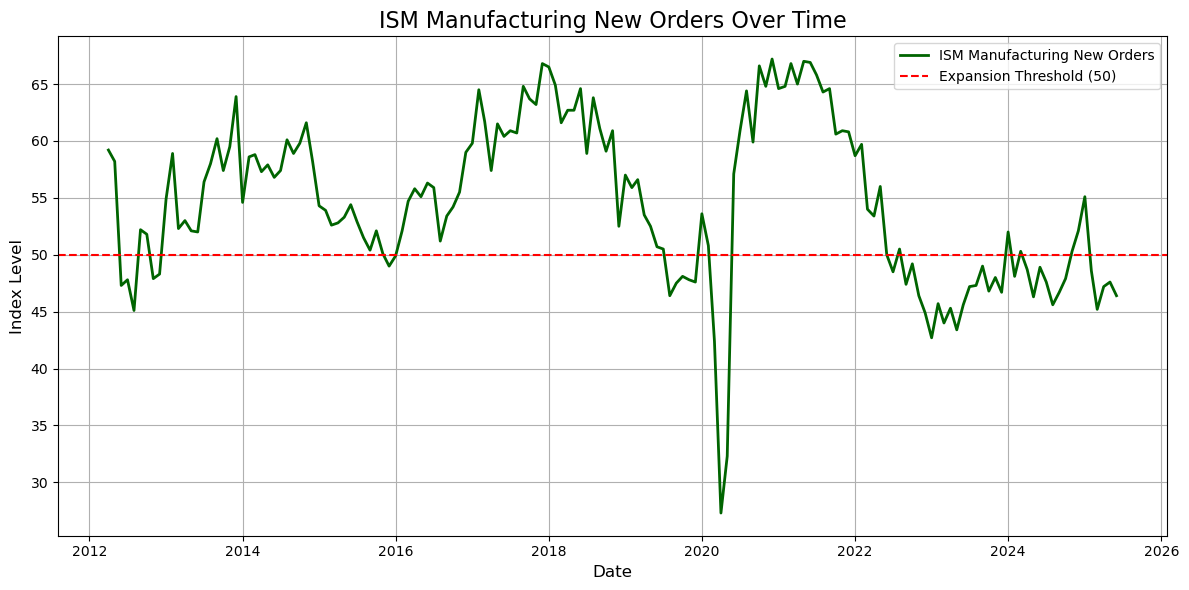

In [142]:

plt.figure(figsize=(12, 6))

plt.plot(
    df_neworder.index,
    df_neworder['ISM New Orders'],
    label='ISM Manufacturing New Orders',
    linewidth=2,
    color='darkgreen'
)

plt.axhline(y=50, color='red', linestyle='--', label='Expansion Threshold (50)')

plt.title('ISM Manufacturing New Orders Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Index Level', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

In [143]:
# Min-Max 归一化
df_neworder['ISM Normalized'] = (
    df_neworder['ISM New Orders'] - df_neworder['ISM New Orders'].min()
) / (
    df_neworder['ISM New Orders'].max() - df_neworder['ISM New Orders'].min()
)

In [144]:
print(df_neworder)

           ISM New Orders ISM Normalized
Date                                    
2012-04-01           59.2       0.799499
2012-05-01           58.2       0.774436
2012-06-01           47.3       0.501253
2012-07-01           47.8       0.513784
2012-08-01           45.1       0.446115
...                   ...            ...
2025-02-01           48.6       0.533835
2025-03-01           45.2       0.448622
2025-04-01           47.2       0.498747
2025-05-01           47.6       0.508772
2025-06-01           46.4       0.478697

[159 rows x 2 columns]


In [145]:
print(df_combined)

            Actual_GDP  Potential_GDP  Output_Gap     4W_MA  Output_Gap_Z  \
DATE                                                                        
1985-01-31    8400.820    8465.293021   -0.761616       NaN     -0.128380   
1985-02-28    8400.820    8465.293021   -0.761616       NaN     -0.128380   
1985-03-31    8400.820    8465.293021   -0.761616       NaN     -0.128380   
1985-04-30    8474.787    8540.419380   -0.768491  382500.0     -0.132195   
1985-05-31    8474.787    8540.419380   -0.768491  389500.0     -0.132195   
...                ...            ...         ...       ...           ...   
2025-03-31   23512.717   23243.220000    1.159465  220250.0      0.937631   
2025-04-30         NaN   23376.070000         NaN  228250.0           NaN   
2025-05-31         NaN   23376.070000         NaN  237750.0           NaN   
2025-06-30         NaN   23376.070000         NaN  235000.0           NaN   
2025-07-31         NaN   23510.180000         NaN  235500.0           NaN   

In [146]:
# 保证索引是 datetime 类型
df_neworder.index = pd.to_datetime(df_neworder.index)
df_combined.index = pd.to_datetime(df_combined.index)

# 把 df_combined 月底 → 下月月初
df_combined.index = (df_combined.index + pd.Timedelta(days=1)).to_period('M').to_timestamp('S')

# 按 neworder 的月初合并
df_merged2 = df_neworder.merge(df_combined, how='left', left_index=True, right_index=True)

In [147]:
print(df_merged2)

           ISM New Orders ISM Normalized  Actual_GDP  Potential_GDP  \
Date                                                                  
2012-04-01           59.2       0.799499   17367.010    17851.54859   
2012-05-01           58.2       0.774436   17444.525    17928.88430   
2012-06-01           47.3       0.501253   17444.525    17928.88430   
2012-07-01           47.8       0.513784   17444.525    17928.88430   
2012-08-01           45.1       0.446115   17469.650    18007.78469   
...                   ...            ...         ...            ...   
2025-02-01           48.6       0.533835   23512.717    23243.22000   
2025-03-01           45.2       0.448622   23512.717    23243.22000   
2025-04-01           47.2       0.498747   23512.717    23243.22000   
2025-05-01           47.6       0.508772         NaN    23376.07000   
2025-06-01           46.4       0.478697         NaN    23376.07000   

            Output_Gap     4W_MA  Output_Gap_Z  Claims_Z  rolling_corr  Regi

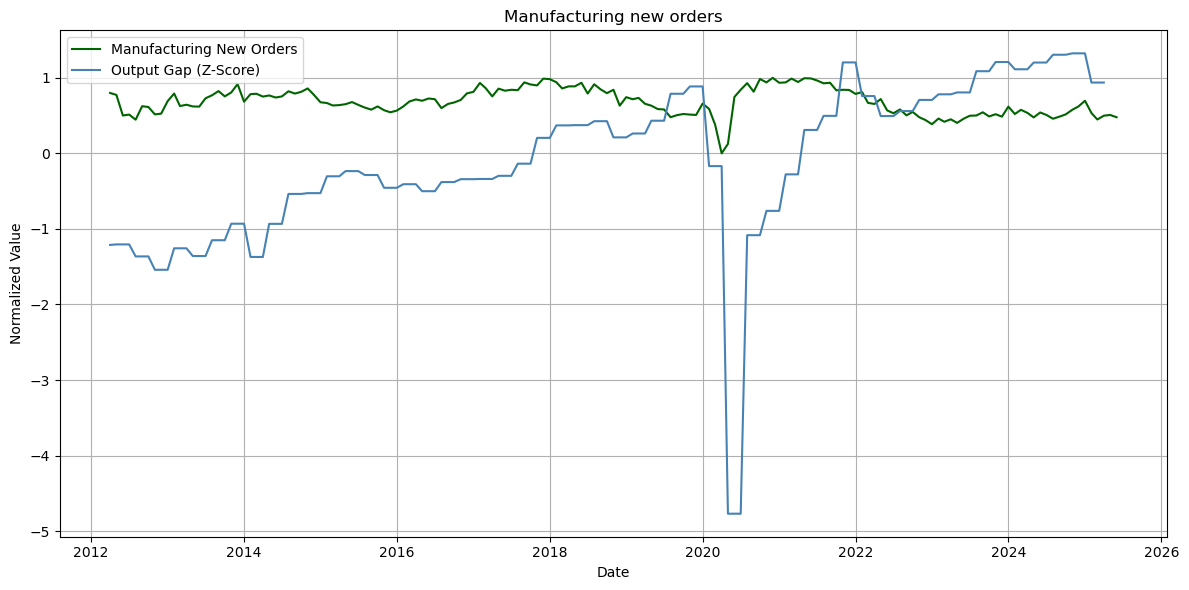

In [148]:
plt.figure(figsize=(12, 6))

plt.plot(df_merged2.index, df_merged2['ISM Normalized'], color='darkgreen', label='Manufacturing New Orders')
plt.plot(df_merged2.index, df_merged2['Output_Gap_Z'], color='steelblue', label='Output Gap (Z-Score)')

plt.title('Manufacturing new orders')
plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.ticklabel_format(style='plain', axis='y')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [149]:
# 取数并转成 float
df_reg = df_merged2[['ISM Normalized', 'Output_Gap_Z']].dropna().astype(float)

In [ ]:
import yfinance as yf
import pandas as pd

etfs = ['XLI', 'XLB', 'XLK', 'XLY']

data = yf.download(etfs, start='2012-01-01', end='2025-07-01')['Adj Close']

monthly_prices = data.resample('M').last()

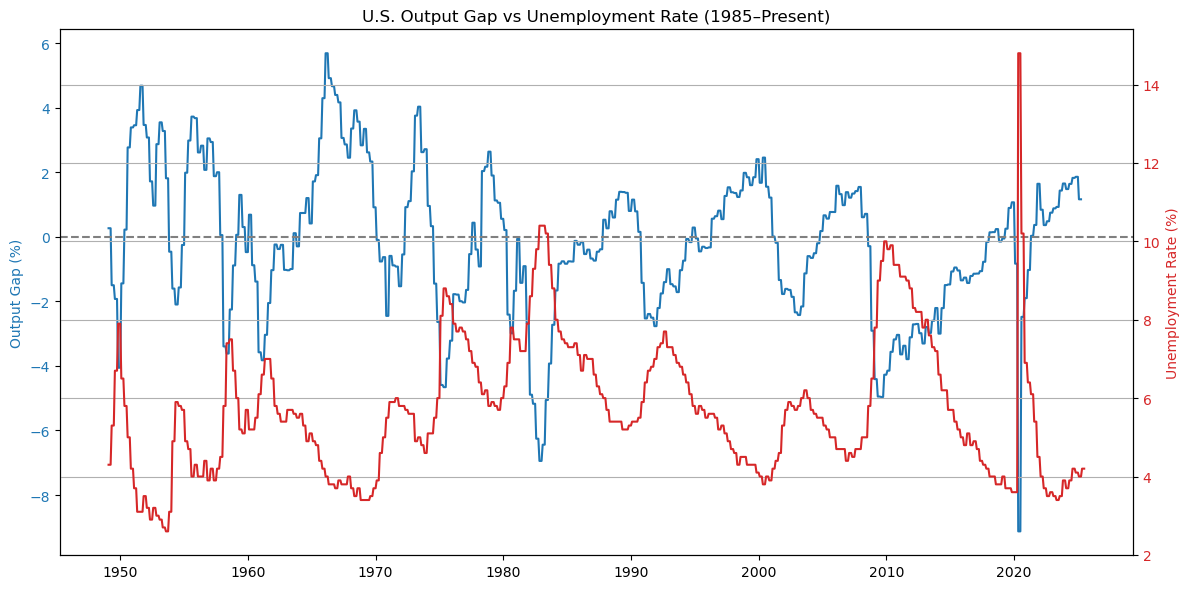

In [151]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pandas_datareader import data as pdr

start_date = '1949-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

# 下载数据
actual_gdp = pdr.DataReader('GDPC1', 'fred', start_date, end_date)
potential_gdp = pdr.DataReader('GDPPOT', 'fred', start_date, end_date)
unrate = pdr.DataReader('UNRATE', 'fred', start_date, end_date)

# 合并数据
df = pd.concat([actual_gdp, potential_gdp], axis=1)
df.columns = ['Actual_GDP', 'Potential_GDP']
df['Output_Gap'] = 100 * (df['Actual_GDP'] - df['Potential_GDP']) / df['Potential_GDP']
df['Unemployment_Rate'] = unrate

# 转换为月度数据
df_monthly = df.resample('M').ffill()

# 可视化：双轴图
plt.figure(figsize=(12, 6))
ax1 = plt.gca()
ax2 = ax1.twinx()

ax1.plot(df_monthly.index, df_monthly['Output_Gap'], label='Output Gap (%)', color='tab:blue')
ax1.set_ylabel('Output Gap (%)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.axhline(0, color='gray', linestyle='--')

ax2.plot(df_monthly.index, df_monthly['Unemployment_Rate'], label='Unemployment Rate (%)', color='tab:red')
ax2.set_ylabel('Unemployment Rate (%)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('U.S. Output Gap vs Unemployment Rate (1985–Present)')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()


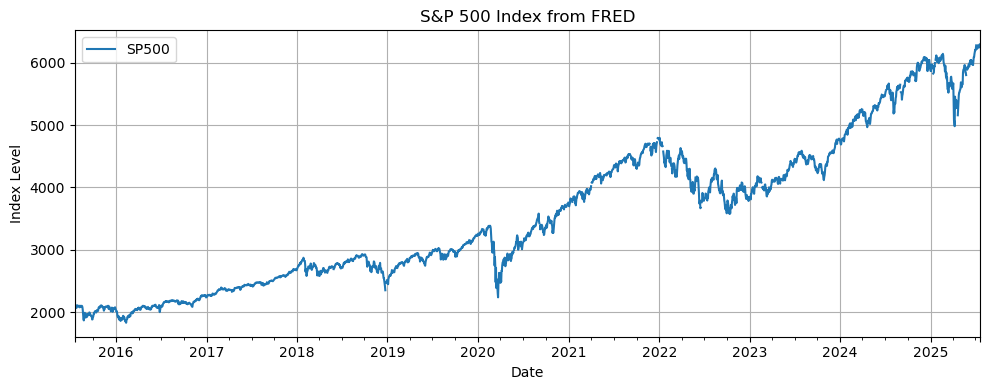

In [152]:
import pandas_datareader.data as pdr
from datetime import datetime
import matplotlib.pyplot as plt

# 设置时间范围
start = '1985-01-01'
end = datetime.today().strftime('%Y-%m-%d')

# 从 FRED 获取 S&P 500 指数（注意：这是月度数据）
sp500 = pdr.DataReader('SP500', 'fred', start, end)

# 可视化
sp500.plot(title='S&P 500 Index from FRED', figsize=(10, 4))
plt.grid(True)
plt.ylabel("Index Level")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

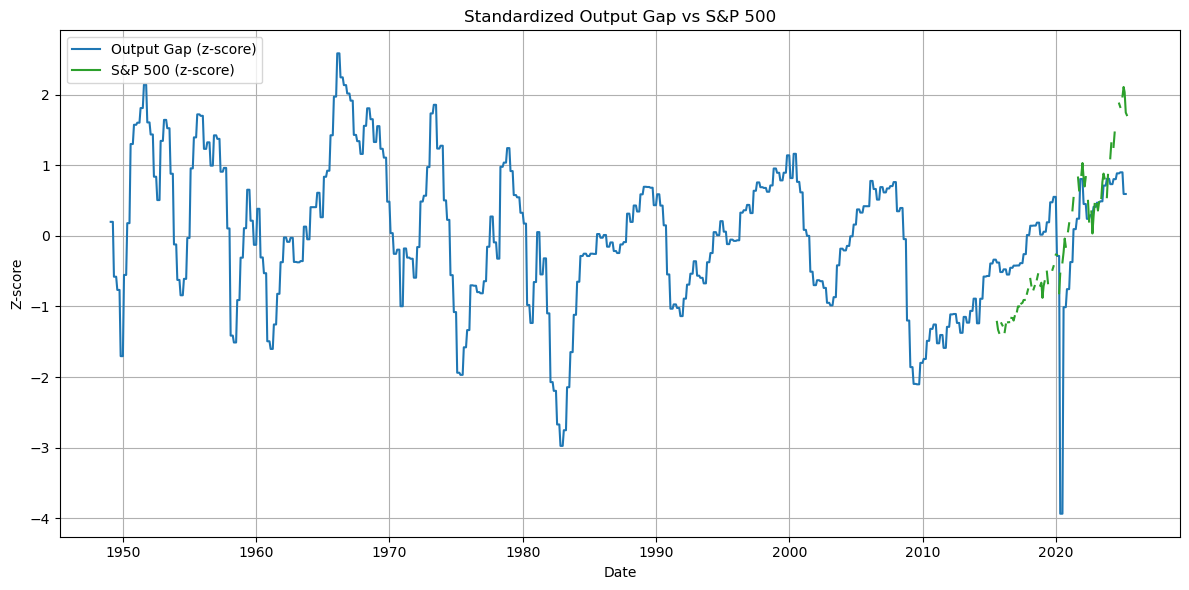

In [153]:
# 合并 S&P 500 到 df_monthly
df_monthly['SP500'] = sp500

from scipy.stats import zscore

# 将 zscore 结果包装成 Series，确保索引匹配
df_monthly['Output_Gap_z'] = pd.Series(zscore(df_monthly['Output_Gap'].dropna()), 
                                       index=df_monthly['Output_Gap'].dropna().index)

df_monthly['SP500_z'] = pd.Series(zscore(df_monthly['SP500'].dropna()), 
                                  index=df_monthly['SP500'].dropna().index)


plt.figure(figsize=(12, 6))
plt.plot(df_monthly.index, df_monthly['Output_Gap_z'], label='Output Gap (z-score)', color='tab:blue')
plt.plot(df_monthly.index, df_monthly['SP500_z'], label='S&P 500 (z-score)', color='tab:green')
plt.title('Standardized Output Gap vs S&P 500')
plt.xlabel('Date')
plt.ylabel('Z-score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [154]:
import statsmodels.api as sm

# 去除缺失值
df_reg = df_monthly[['SP500_z', 'Output_Gap_z']].dropna()

# 自变量（X）和因变量（Y）
X = df_reg['SP500_z']
y = df_reg['Output_Gap_z']

# 添加常数项（intercept）
X = sm.add_constant(X)

# 拟合 OLS 模型
model = sm.OLS(y, X).fit()

# 打印回归结果
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Output_Gap_z   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     30.12
Date:                Mon, 21 Jul 2025   Prob (F-statistic):           4.43e-07
Time:                        14:05:14   Log-Likelihood:                -86.910
No. Observations:                  84   AIC:                             177.8
Df Residuals:                      82   BIC:                             182.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0335      0.075      0.445      0.6

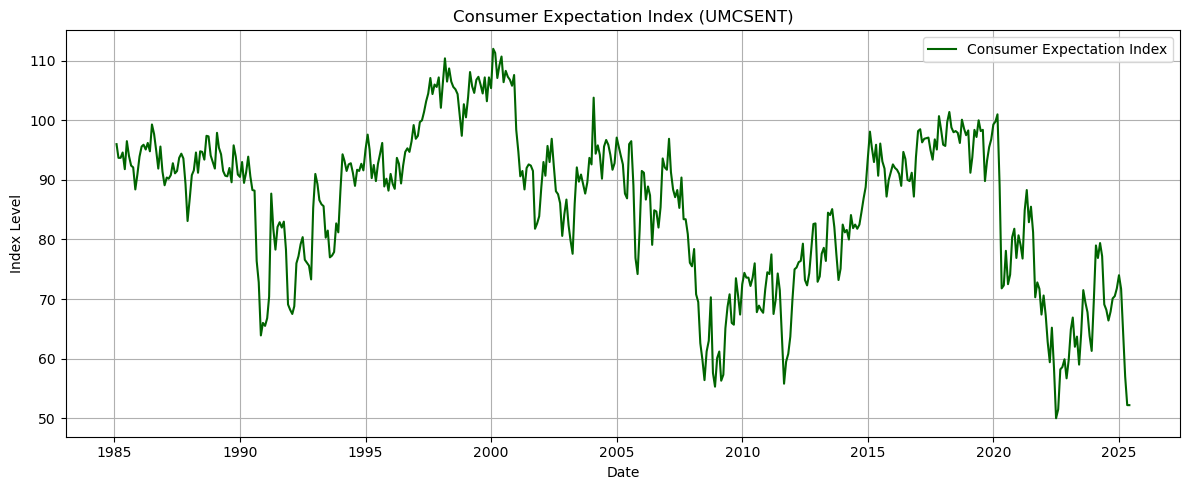

In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas_datareader import data as pdr

# === 1. 获取 UMCSENT ===
start_date = '1985-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

umcsent = pdr.DataReader('UMCSENT', 'fred', start_date, end_date)
umcsent = umcsent.resample('M').last()

# # === 2. 计算同比增速（YoY）并标准化 ===
# df = pd.DataFrame(index=umcsent.index)
# df['UMCSENT_YoY'] = umcsent.pct_change(12) * 100
# df_clean = df.dropna()
# df_std = (df_clean - df_clean.mean()) / df_clean.std()

# # === 3. 绘图 ===
# plt.figure(figsize=(12, 5))
# plt.plot(df_std.index, df_std['UMCSENT_YoY'], label='Consumer Sentiment YoY (Standardized)', color='darkgreen')
# plt.title("Standardized YoY Growth: Consumer Sentiment Index (UMCSENT)")
# plt.xlabel("Date")
# plt.ylabel("Z-score")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()

# === 3. 绘图 ===
plt.figure(figsize=(12, 5))
plt.plot(umcsent.index, umcsent['UMCSENT'], label='Consumer Expectation Index', color='darkgreen')
plt.title("Consumer Expectation Index (UMCSENT)")
plt.xlabel("Date")
plt.ylabel("Index Level")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

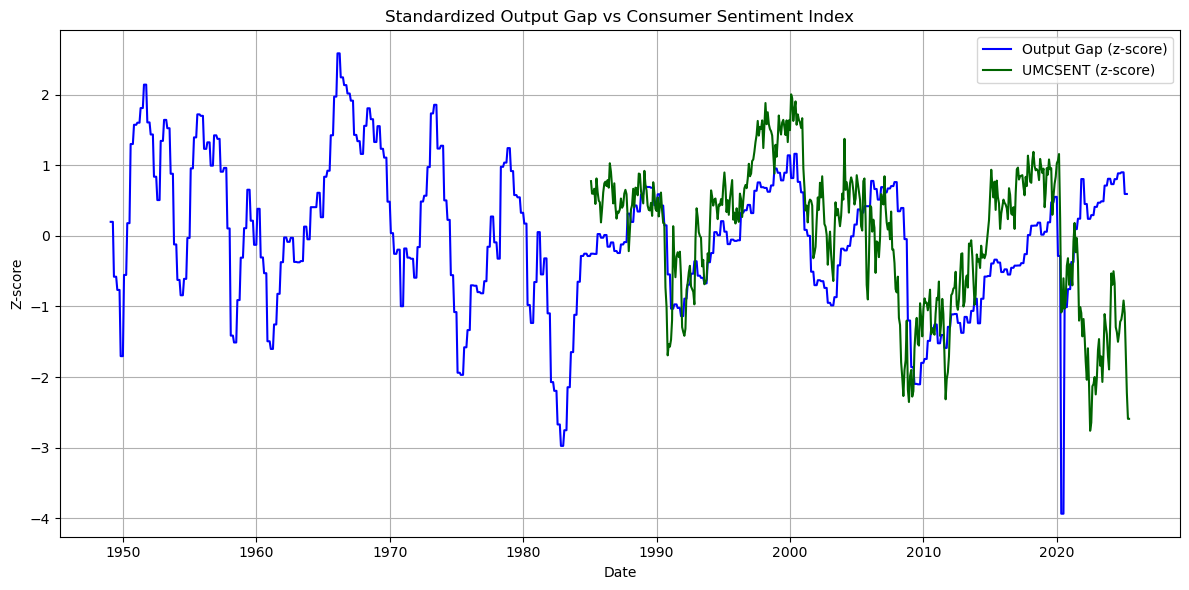

In [156]:
# 确保 umcsent 的列名一致
umcsent.columns = ['UMCSENT']

# 合并到 df_monthly
df_monthly = df_monthly.join(umcsent, how='left')

from scipy.stats import zscore

# 只对非缺失部分做 z-score，并保持索引一致
df_monthly['UMCSENT_z'] = pd.Series(zscore(df_monthly['UMCSENT'].dropna()), 
                                    index=df_monthly['UMCSENT'].dropna().index)

df_monthly['Output_Gap_z'] = pd.Series(zscore(df_monthly['Output_Gap'].dropna()), 
                                       index=df_monthly['Output_Gap'].dropna().index)

plt.figure(figsize=(12, 6))
plt.plot(df_monthly.index, df_monthly['Output_Gap_z'], label='Output Gap (z-score)', color='blue')
plt.plot(df_monthly.index, df_monthly['UMCSENT_z'], label='UMCSENT (z-score)', color='darkgreen')
plt.title('Standardized Output Gap vs Consumer Sentiment Index')
plt.xlabel('Date')
plt.ylabel('Z-score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [157]:
import statsmodels.api as sm

# 去除缺失值
df_reg = df_monthly[['UMCSENT_z', 'Output_Gap_z']].dropna()

# 自变量（X）和因变量（Y）
X = df_reg['UMCSENT_z']
y = df_reg['Output_Gap_z']

# 添加常数项（intercept）
X = sm.add_constant(X)

# 拟合 OLS 模型
model = sm.OLS(y, X).fit()

# 打印回归结果
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Output_Gap_z   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     101.8
Date:                Mon, 21 Jul 2025   Prob (F-statistic):           7.73e-22
Time:                        14:05:14   Log-Likelihood:                -526.86
No. Observations:                 483   AIC:                             1058.
Df Residuals:                     481   BIC:                             1066.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1544      0.033     -4.702      0.0

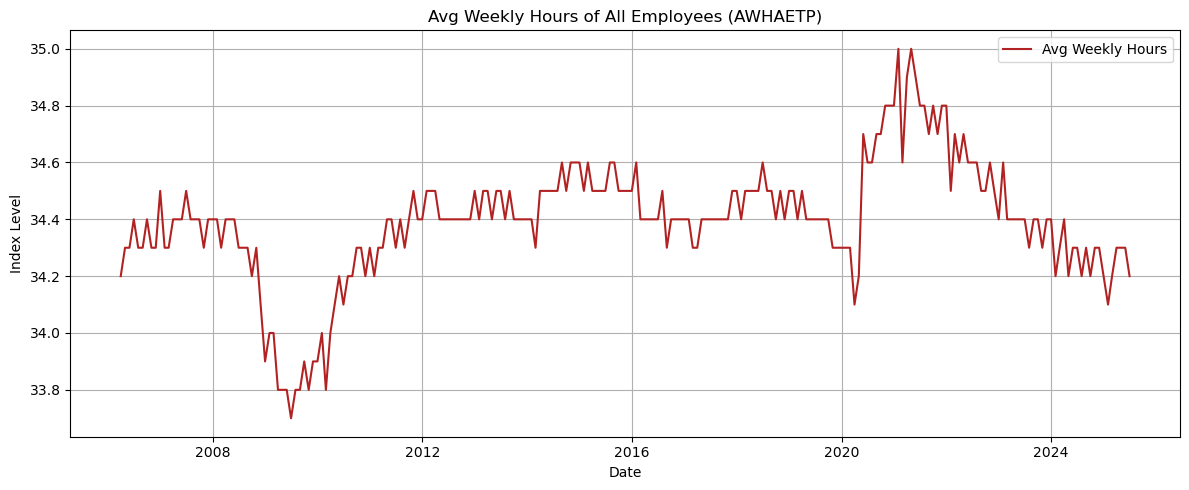

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas_datareader import data as pdr

# === 1. 获取 AWHAETP 数据 ===
start_date = '1985-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

awh = pdr.DataReader('AWHAETP', 'fred', start_date, end_date)
awh = awh.resample('M').last()

# # === 2. 计算同比增速（YoY）并标准化 ===
# df = pd.DataFrame(index=awh.index)
# df['AWHAETP_YoY'] = awh.pct_change(12) * 100
# df_clean = df.dropna()
# df_std = (df_clean - df_clean.mean()) / df_clean.std()

# === 3. 绘图：标准化 YoY 曲线 ===
plt.figure(figsize=(12, 5))
plt.plot(awh.index, awh['AWHAETP'], label='Avg Weekly Hours', color='firebrick')
plt.title("Avg Weekly Hours of All Employees (AWHAETP)")
plt.xlabel("Date")
plt.ylabel("Index Level")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

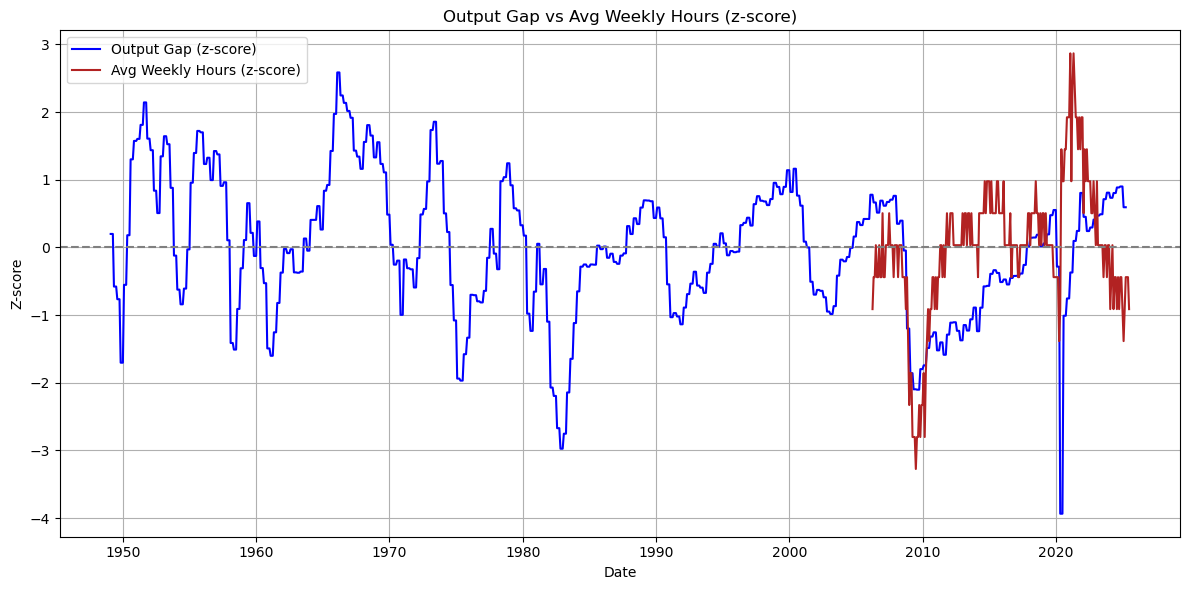

In [159]:
from scipy.stats import zscore

# 确保列名一致，防止冲突
awh.columns = ['AWHAETP']

# 合并数据（避免列重复）
if 'AWHAETP' not in df_monthly.columns:
    df_monthly = df_monthly.join(awh, how='left')

df_monthly['Output_Gap_z'] = pd.Series(zscore(df_monthly['Output_Gap'].dropna()),
                                       index=df_monthly['Output_Gap'].dropna().index)

df_monthly['AWHAETP_z'] = pd.Series(zscore(df_monthly['AWHAETP'].dropna()),
                                    index=df_monthly['AWHAETP'].dropna().index)

plt.figure(figsize=(12, 6))
plt.plot(df_monthly.index, df_monthly['Output_Gap_z'], label='Output Gap (z-score)', color='blue')
plt.plot(df_monthly.index, df_monthly['AWHAETP_z'], label='Avg Weekly Hours (z-score)', color='firebrick')
plt.title('Output Gap vs Avg Weekly Hours (z-score)')
plt.xlabel('Date')
plt.ylabel('Z-score')
plt.axhline(0, color='gray', linestyle='--')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [160]:
import statsmodels.api as sm

# 去除缺失值
df_reg = df_monthly[['AWHAETP_z', 'Output_Gap_z']].dropna()

# 自变量（X）和因变量（Y）
X = df_reg['AWHAETP_z']
y = df_reg['Output_Gap_z']

# 添加常数项（intercept）
X = sm.add_constant(X)

# 拟合 OLS 模型
model = sm.OLS(y, X).fit()

# 打印回归结果
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           Output_Gap_z   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     20.33
Date:                Mon, 21 Jul 2025   Prob (F-statistic):           1.05e-05
Time:                        14:05:15   Log-Likelihood:                -300.19
No. Observations:                 229   AIC:                             604.4
Df Residuals:                     227   BIC:                             611.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3655      0.060     -6.134      0.0

In [161]:
# 设置时间区间
start_date = '1985-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

# === 1. M2 YoY 增速 ===
m2 = pdr.DataReader('M2SL', 'fred', start_date, end_date)
m2_yoy = m2.pct_change(periods=12) * 100
m2_yoy.rename(columns={'M2SL': 'M2_YoY'}, inplace=True)

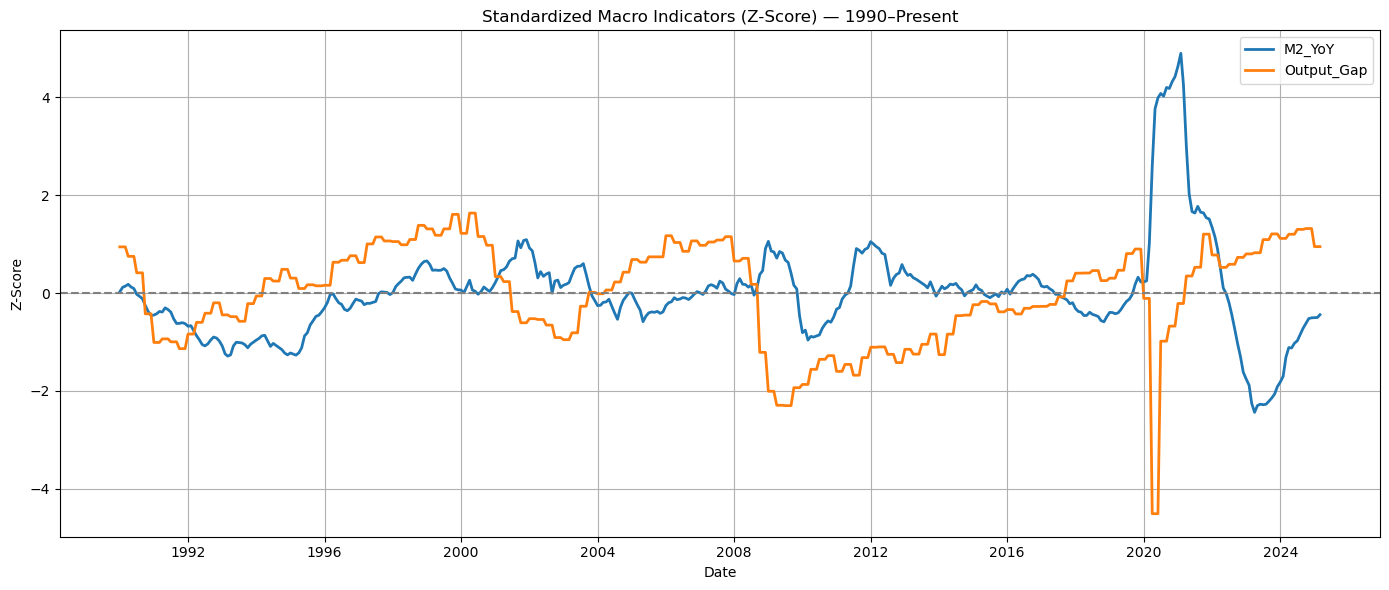

In [162]:
m2_yoy.index = m2_yoy.index.to_period('M').to_timestamp()
df_monthly.index = df_monthly.index.to_period('M').to_timestamp()  # 你原来的 Output Gap

df_all = pd.concat([
    m2_yoy,
    df_monthly[['Output_Gap']]
], axis=1)

df_all = df_all.loc['1990-01-01':]

df_clean = df_all.dropna()
df_standardized = (df_clean - df_clean.mean()) / df_clean.std()

plt.figure(figsize=(14, 6))
for col in df_standardized.columns:
    plt.plot(df_standardized.index, df_standardized[col], label=col, linewidth=2)

plt.title("Standardized Macro Indicators (Z-Score) — 1990–Present")
plt.xlabel("Date")
plt.ylabel("Z-Score")
plt.axhline(0, linestyle='--', color='gray')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

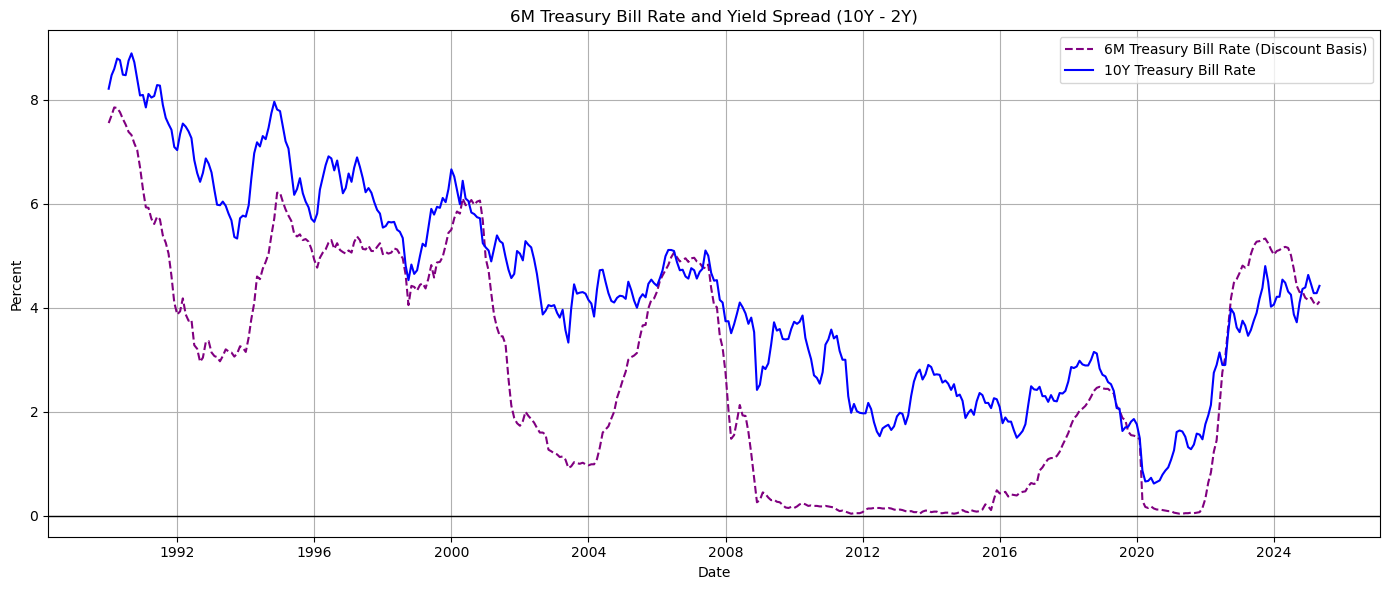

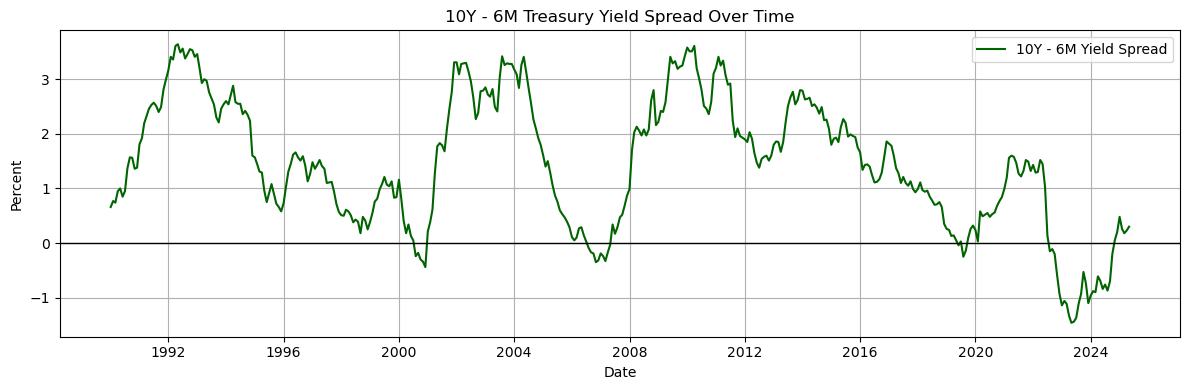

In [163]:
df_tb = pd.read_csv("fredgraph.csv")

df_tb.columns = df_tb.columns.str.strip()
df_tb = df_tb.rename(columns={
    'observation_date': 'Date',
    'DGS10': 'TBill_10Y',
    'DTB6': 'TBill_6M'
})


df_tb['Date'] = pd.to_datetime(df_tb['Date'])

df_tb['10Y_minus_6M'] = df_tb['TBill_10Y'] - df_tb['TBill_6M']

df_tb['Date'] = pd.to_datetime(df_tb['Date'])
#figure 1
plt.figure(figsize=(14, 6))
plt.plot(df_tb['Date'], df_tb['TBill_6M'], label='6M Treasury Bill Rate (Discount Basis)', linestyle='--', color='purple')
plt.plot(df_tb['Date'], df_tb['TBill_10Y'], label='10Y Treasury Bill Rate', color='blue')
plt.axhline(0, color='black', linewidth=1)
plt.title("6M Treasury Bill Rate and Yield Spread (10Y - 2Y)")
plt.ylabel("Percent")
plt.xlabel("Date")
plt.grid(True)
plt.legend()
plt.tight_layout()
#figure2
plt.show()
plt.figure(figsize=(12, 4))
plt.plot(df_tb['Date'], df_tb['10Y_minus_6M'], label='10Y - 6M Yield Spread', color='darkgreen')
plt.axhline(0, color='black', linewidth=1)
plt.title("10Y - 6M Treasury Yield Spread Over Time")
plt.xlabel("Date")
plt.ylabel("Percent")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

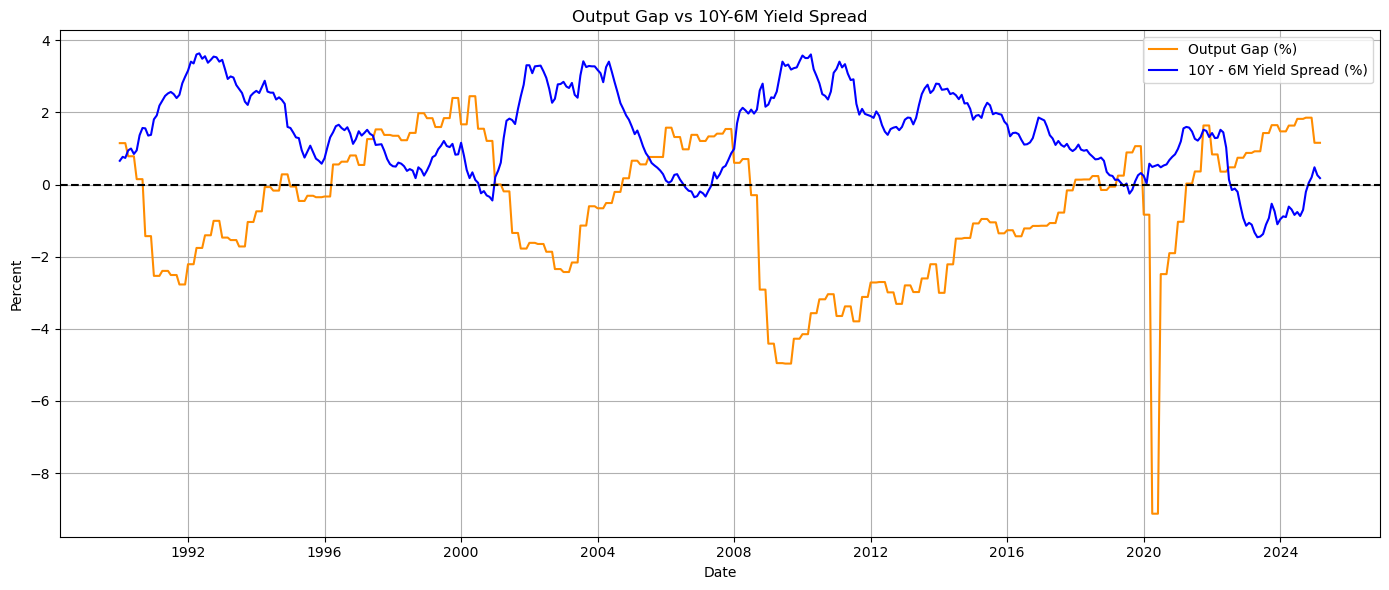

In [164]:
df_tb['Date'] = pd.to_datetime(df_tb['Date'])
df_tb = df_tb.set_index('Date')
df_plot = pd.concat([df_monthly[['Output_Gap']], df_tb[['10Y_minus_6M']]], axis=1)
df_plot = df_plot.dropna()

# plot
plt.figure(figsize=(14, 6))
plt.plot(df_plot.index, df_plot['Output_Gap'], label='Output Gap (%)', color='darkorange')
plt.plot(df_plot.index, df_plot['10Y_minus_6M'], label='10Y - 6M Yield Spread (%)', color='blue')
plt.axhline(0, color='black', linestyle='--')
plt.title("Output Gap vs 10Y-6M Yield Spread")
plt.xlabel("Date")
plt.ylabel("Percent")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [165]:
df_tb['10Y_minus_6M_lag1'] = df_tb['10Y_minus_6M'].shift(1)
df_all['M2_YoY_lag1'] = df_all['M2_YoY'].shift(1)
df_all = df_all.merge(
    df_tb[['10Y_minus_6M', '10Y_minus_6M_lag1']],
    left_index=True, right_index=True, how='left'
)

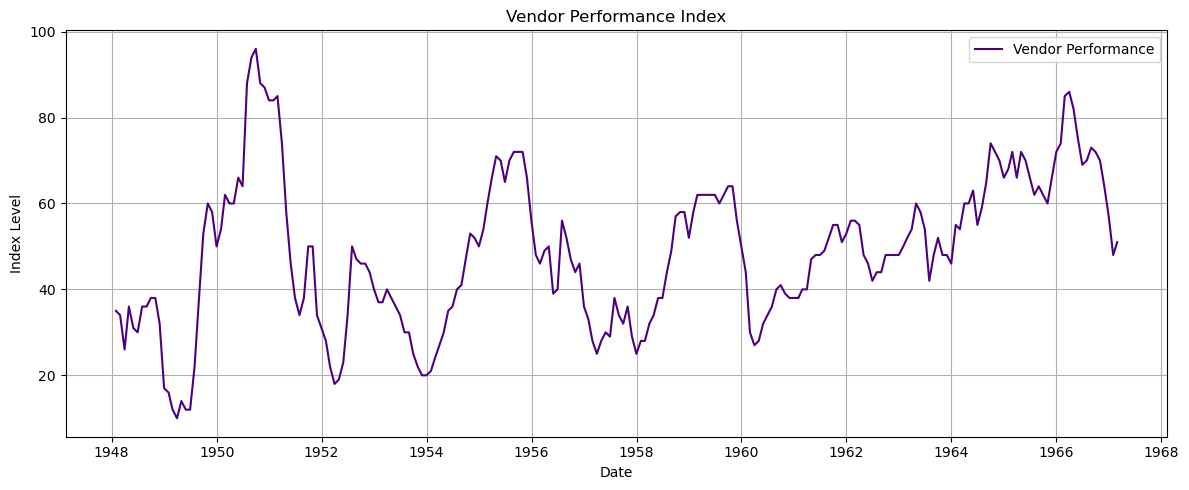

In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas_datareader import data as pdr

# === 1. 获取 Vendor Performance 数据（单位为%）===
start_date = '1948-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

vendor = pdr.DataReader('M06006USM156NNBR', 'fred', start_date, end_date)
vendor = vendor.resample('M').last()  # 有些月份缺失，需要补成月频

# # === 2. 计算同比增速（单位已是百分比，不乘100）===
# df = pd.DataFrame(index=vendor.index)
# df['Vendor_YoY'] = vendor.pct_change(12)

# # === 3. 清洗 + 标准化 ===
# df_clean = df.dropna()
# df_std = (df_clean - df_clean.mean()) / df_clean.std()

# === 4. 绘图：标准化趋势 ===
plt.figure(figsize=(12, 5))
plt.plot(vendor.index, vendor['M06006USM156NNBR'], label='Vendor Performance', color='indigo')
plt.title("Vendor Performance Index")
plt.xlabel("Date")
plt.ylabel("Index Level")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# # === 5. 滞后 12 个月自相关 ===
# df_lagged = df_clean.copy()
# df_lagged['Vendor_YoY_lag12'] = df_lagged['Vendor_YoY'].shift(12)

# print("【Vendor Performance：当前与滞后12个月的自相关】")
# print(df_lagged[['Vendor_YoY', 'Vendor_YoY_lag12']].dropna().corr())


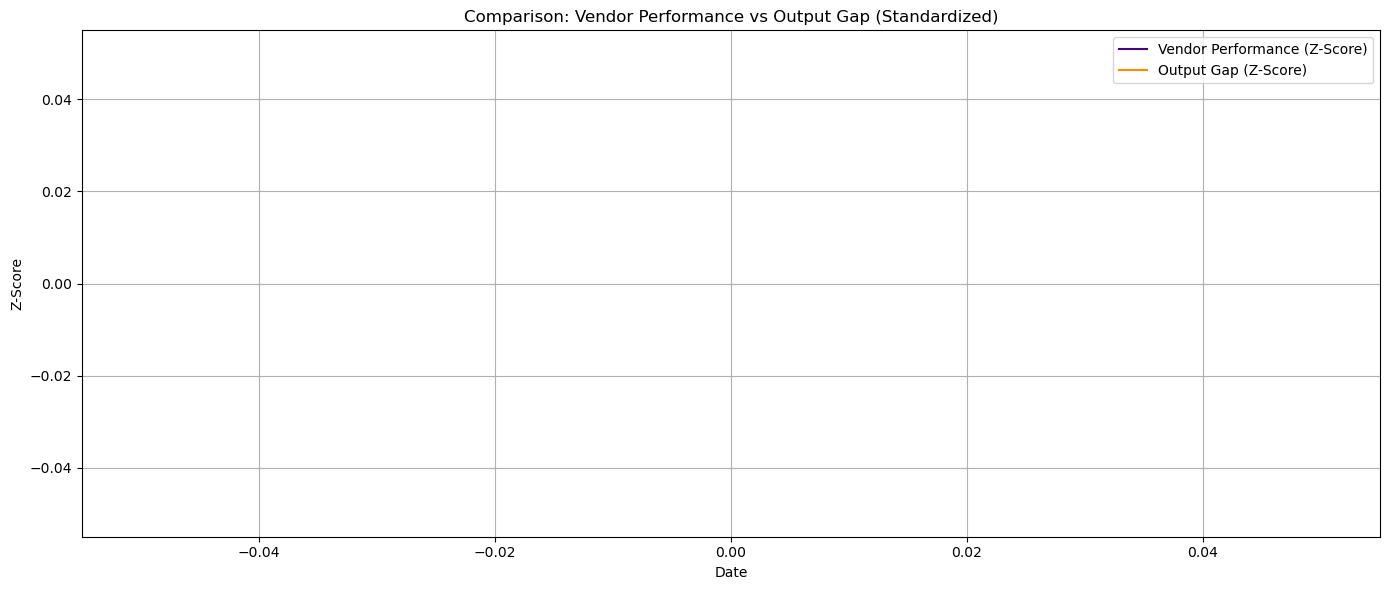

In [167]:
vendor_clean = vendor.dropna()
vendor_clean['Vendor_z'] = zscore(vendor_clean['M06006USM156NNBR'])

output_gap = df_monthly[['Output_Gap_z']].dropna()

combined = pd.merge(vendor_clean[['Vendor_z']], output_gap, left_index=True, right_index=True, how='inner')

plt.figure(figsize=(14, 6))
plt.plot(combined.index, combined['Vendor_z'], label='Vendor Performance (Z-Score)', color='indigo')
plt.plot(combined.index, combined['Output_Gap_z'], label='Output Gap (Z-Score)', color='darkorange')
plt.title('Comparison: Vendor Performance vs Output Gap (Standardized)')
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [168]:
import statsmodels.api as sm

# 1. 自变量 X（Vendor Performance）
X = combined['Vendor_z']
# 加常数项 intercept
X = sm.add_constant(X)

# 2. 因变量 Y（Output Gap）
Y = combined['Output_Gap_z']

# 3. 建立OLS模型并拟合
model = sm.OLS(Y, X).fit()

# 4. 输出回归结果摘要
print(model.summary())


ValueError: zero-size array to reduction operation maximum which has no identity

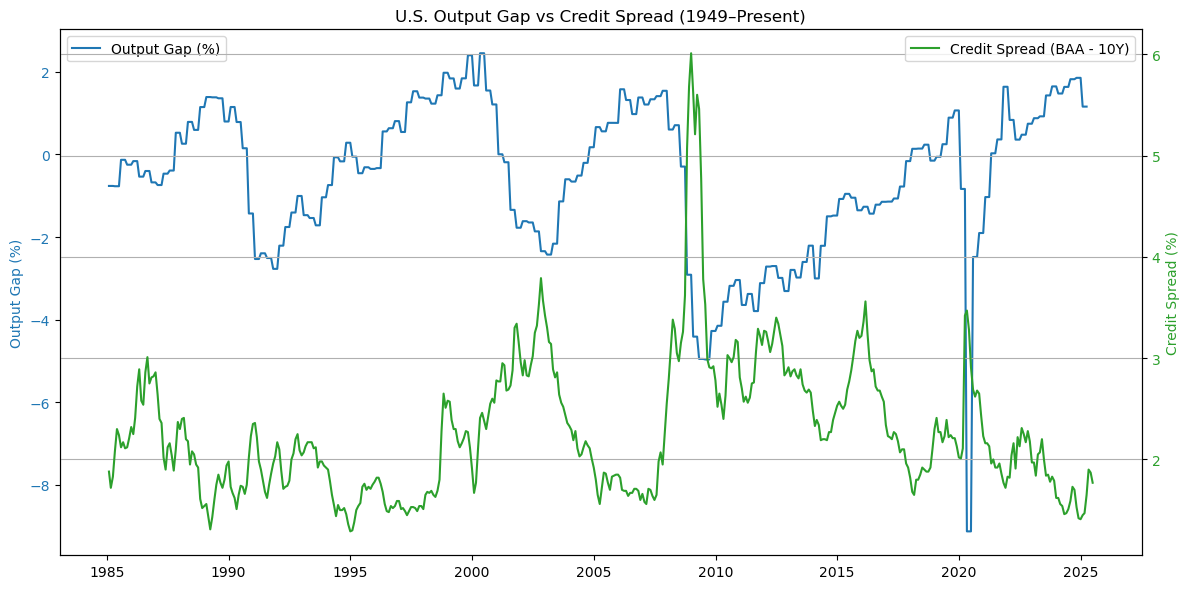

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pandas_datareader import data as pdr

# 设置时间范围
start_date = '1985-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

# 下载季度GDP数据
actual_gdp = pdr.DataReader('GDPC1', 'fred', start_date, end_date)
potential_gdp = pdr.DataReader('GDPPOT', 'fred', start_date, end_date)

# 合并并计算Output Gap
gdp_df = pd.concat([actual_gdp, potential_gdp], axis=1)
gdp_df.columns = ['Actual_GDP', 'Potential_GDP']
gdp_df['Output_Gap'] = 100 * (gdp_df['Actual_GDP'] - gdp_df['Potential_GDP']) / gdp_df['Potential_GDP']
gdp_df = gdp_df.resample('M').ffill()  # 转为月度并前向填充

# Credit Spread
# 下载信用利差相关数据
baa_yield = pdr.DataReader('BAA', 'fred', start_date, end_date)
treasury_yield = pdr.DataReader('GS10', 'fred', start_date, end_date)

credit_df = pd.concat([baa_yield, treasury_yield], axis=1)
credit_df.columns = ['BAA_Yield', 'Treasury_Yield']
credit_df['Credit_Spread'] = credit_df['BAA_Yield'] - credit_df['Treasury_Yield']

# 修正索引：将月初对齐为月末
credit_df.index = credit_df.index.to_period('M').to_timestamp('M')

# 合并为一个DataFrame，确保索引对齐
df = gdp_df[['Output_Gap']].join(credit_df[['Credit_Spread']], how='inner')

# 绘图
plt.figure(figsize=(12, 6))
ax1 = plt.gca()
ax2 = ax1.twinx()

# Output Gap (左轴)
ax1.plot(df.index, df['Output_Gap'], label='Output Gap (%)', color='tab:blue')
ax1.set_ylabel('Output Gap (%)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Credit Spread (右轴)
ax2.plot(df.index, df['Credit_Spread'], label='Credit Spread (BAA - 10Y)', color='tab:green')
ax2.set_ylabel('Credit Spread (%)', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')

# 标题与图例
plt.title('U.S. Output Gap vs Credit Spread (1949–Present)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()


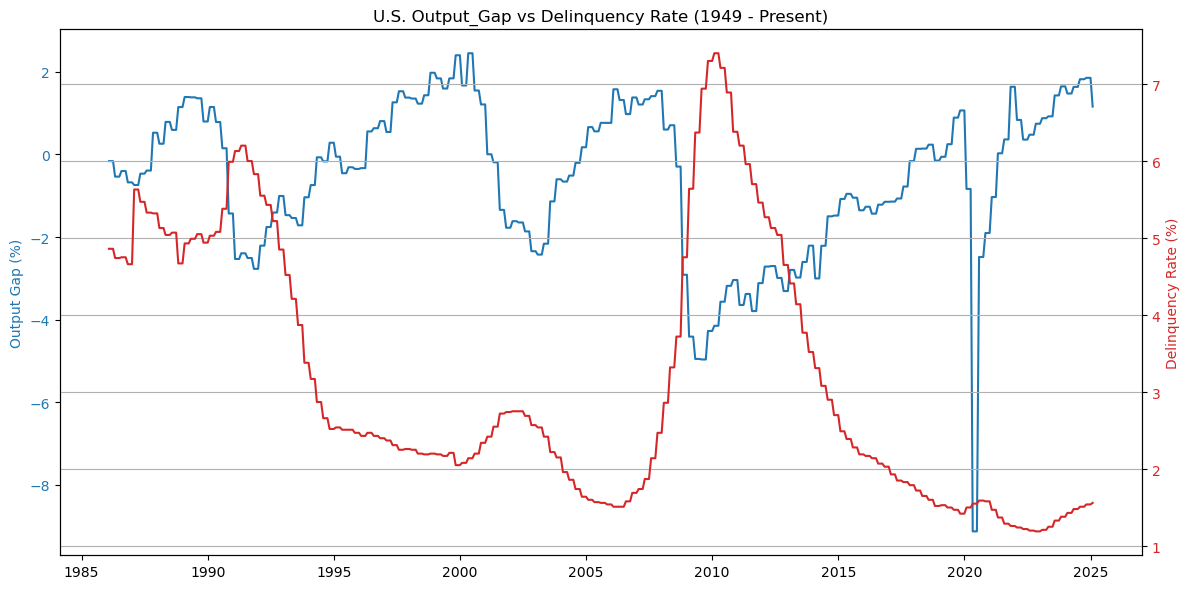

In [ ]:
# Delinquency Rate
# 下载违约率（美国所有贷款违约率）
delinquency = pdr.DataReader('DRALACBS', 'fred', start_date, end_date).resample('M').ffill()

#loan
loans = pdr.DataReader('TOTLL', 'fred', start_date, end_date).resample('M').ffill()
loan_growth = loans.pct_change(periods=12) * 100

df2 = gdp_df[['Output_Gap']].join([delinquency,loan_growth],how = 'inner')
df2.columns = ['Output_Gap', 'Delinquency_Rate', 'Loan_Growth']
df2.dropna(inplace=True)

plt.figure(figsize = (12,6))
ax1 = plt.gca()
ax2 = ax1.twinx()

ax2.plot(df2.index, df2['Delinquency_Rate'], color='tab:red', label='Delinquency Rate (%)')
ax2.set_ylabel('Delinquency Rate (%)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

ax1.plot(df2.index, df2['Output_Gap'], label='Output Gap (%)', color='tab:blue')
ax1.set_ylabel('Output Gap (%)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

plt.title('U.S. Output_Gap vs Delinquency Rate (1949 - Present)')
plt.grid(True)
plt.tight_layout()
plt.show()

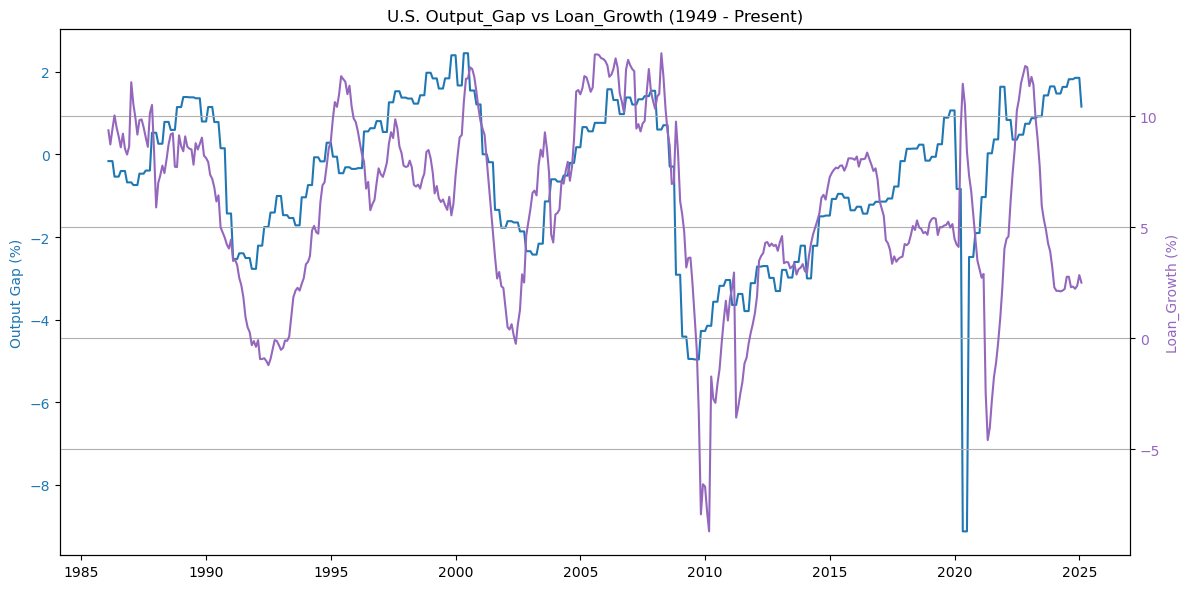

In [ ]:
# Loan Growth

plt.figure(figsize = (12,6))
ax1 = plt.gca()
ax2 = ax1.twinx()

ax2.plot(df2.index, df2['Loan_Growth'], color='tab:purple', label='Loan_Growth (%)')
ax2.set_ylabel('Loan_Growth (%)', color='tab:purple')
ax2.tick_params(axis='y', labelcolor='tab:purple')

ax1.plot(df2.index, df2['Output_Gap'], label='Output Gap (%)', color='tab:blue')
ax1.set_ylabel('Output Gap (%)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

plt.title('U.S. Output_Gap vs Loan_Growth (1949 - Present)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# STATA
import statsmodels.api as sm
from scipy import stats

r1, p1 = stats.pearsonr(df2['Output_Gap'], df2['Delinquency_Rate'])
r2, p2 = stats.pearsonr(df2['Output_Gap'], df2['Loan_Growth'])
r3, p3 = stats.pearsonr(df['Output_Gap'], df['Credit_Spread'])

print("=== Pearson Correlation (r, p) ===")
print(f"Output Gap ~ Delinquency Rate: r = {r1:.3f}, p = {p1:.3e}")
X1 = sm.add_constant(df2[['Delinquency_Rate']])
model1 = sm.OLS(df2['Output_Gap'], X1).fit()
print("\n=== Regression: Output_Gap ~ Delinquency_Rate ===")
print(model1.summary())



=== Pearson Correlation (r, p) ===
Output Gap ~ Delinquency Rate: r = -0.535, p = 4.988e-36

=== Regression: Output_Gap ~ Delinquency_Rate ===
                            OLS Regression Results                            
Dep. Variable:             Output_Gap   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     186.9
Date:                Mon, 21 Jul 2025   Prob (F-statistic):           4.99e-36
Time:                        13:16:59   Log-Likelihood:                -868.15
No. Observations:                 469   AIC:                             1740.
Df Residuals:                     467   BIC:                             1749.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [

In [ ]:
print("=== Pearson Correlation (r, p) ===")
print(f"Output Gap ~ Loan Growth    : r = {r2:.3f}, p = {p2:.3e}")
X2 = sm.add_constant(df2[['Loan_Growth']])
model2 = sm.OLS(df2['Output_Gap'], X2).fit()
print("\n=== Regression: Output_Gap ~ Loan_Growth ===")
print(model2.summary())

=== Pearson Correlation (r, p) ===
Output Gap ~ Loan Growth    : r = 0.506, p = 8.170e-32

=== Regression: Output_Gap ~ Loan_Growth ===
                            OLS Regression Results                            
Dep. Variable:             Output_Gap   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     160.4
Date:                Mon, 21 Jul 2025   Prob (F-statistic):           8.17e-32
Time:                        13:17:02   Log-Likelihood:                -877.84
No. Observations:                 469   AIC:                             1760.
Df Residuals:                     467   BIC:                             1768.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0

In [ ]:

df_clean = df[['Output_Gap', 'Credit_Spread']].dropna()
print("=== Pearson Correlation (r, p) ===")
print(f"Output Gap ~ Credit Spread   : r = {r3:.3f}, p = {p3:.3e}")
X3 = sm.add_constant(df_clean[['Credit_Spread']])
model3 = sm.OLS(df_clean['Output_Gap'], X3).fit()
print("\n=== Regression: Output_Gap ~ Credit_Spread ===")
print(model3.summary())

=== Pearson Correlation (r, p) ===
Output Gap ~ Credit Spread   : r = nan, p = nan

=== Regression: Output_Gap ~ Credit_Spread ===
                            OLS Regression Results                            
Dep. Variable:             Output_Gap   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     290.9
Date:                Mon, 21 Jul 2025   Prob (F-statistic):           2.31e-51
Time:                        13:17:04   Log-Likelihood:                -855.08
No. Observations:                 483   AIC:                             1714.
Df Residuals:                     481   BIC:                             1723.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.97

In [ ]:
#multi
df_full = df2[['Output_Gap', 'Delinquency_Rate', 'Loan_Growth']].join(df[['Credit_Spread']], how='inner')
df_full.dropna(inplace=True)

X = sm.add_constant(df_full[['Delinquency_Rate', 'Loan_Growth', 'Credit_Spread']])
y = df_full['Output_Gap']

model_all = sm.OLS(y, X).fit()

print("=== Regression: Output_Gap ~ Delinquency + Loan Growth + Credit Spread ===")
print(model_all.summary())

=== Regression: Output_Gap ~ Delinquency + Loan Growth + Credit Spread ===
                            OLS Regression Results                            
Dep. Variable:             Output_Gap   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     224.7
Date:                Mon, 21 Jul 2025   Prob (F-statistic):           4.49e-90
Time:                        13:17:06   Log-Likelihood:                -736.99
No. Observations:                 469   AIC:                             1482.
Df Residuals:                     465   BIC:                             1499.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------